# Synthetic Data Generation Baseline

In [1]:
import os, sys
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import json
import pickle
import sklearn
import tqdm.notebook as tqdm

from sklearn.model_selection import train_test_split
sns.set_theme()
sys.path.append(os.path.abspath('..'))

In [2]:
%load_ext autoreload
%autoreload 2

from lib.vae_models import VAE, CVAE
import lib.datasets as datasets
import lib.utils as utils
from lib.lda_lib import EntityEncoder

#### Import Data

In [3]:
DATASET_NAME = 'goi4_dp_small_2yrs_inpost'
RANDOM_SEED = 2112
np.random.seed(RANDOM_SEED)

In [4]:
df = pd.read_csv(f'../data/{DATASET_NAME}/dataset.csv')
data, dates, users = df.iloc[:,:-2].values, df.date.values, df.user.values
date_ids, user_ids = df.date.unique(), df.user.unique()
num_days, num_users = len(date_ids), len(user_ids)
print(f'Loaded {len(data)} consumption profiles from {num_days} dates and {num_users} users')

Loaded 1011780 consumption profiles from 730 dates and 1386 users


In [5]:
date_dict = np.load(f'../data/{DATASET_NAME}/encode_dict.npy', allow_pickle=True).item()["date_dict"]
date_dict_inv = {v: k for k, v in date_dict.items()}

In [6]:
if not os.path.exists(f'../data/{DATASET_NAME}/raw_dates.npy'):
    raw_dates = np.array([datetime.datetime.strptime(date_dict_inv[d], '%Y-%m-%d') for d in dates])
    np.save(f'../data/{DATASET_NAME}/raw_dates.npy', raw_dates)
else:
    raw_dates = np.load(f'../data/{DATASET_NAME}/raw_dates.npy', allow_pickle=True)

In [7]:
metadata = pd.read_csv(f'../data/{DATASET_NAME}/metadata.csv')

In [8]:
unique_provinces = metadata.province.unique()
print(f'Loaded metadata for {len(unique_provinces)} provinces')
print(f"Uniqe provinces are: {unique_provinces}")

Loaded metadata for 29 provinces
Uniqe provinces are: ['Bizkaia' 'Gipuzkoa' 'Navarra' 'La Rioja' 'Madrid' 'Palencia' 'Cantabria'
 'Araba/Alava' 'Valencia/Valencia' 'Burgos' 'Cuenca' 'Coruna A' 'Murcia'
 'Salamanca' 'Cadiz' 'Tarragona' 'Jaen' 'Huesca' 'Cordoba' 'Soria'
 'Ourense' 'Zaragoza' 'Barcelona' 'Guadalajara' 'Caceres'
 'Alicante/Alacant' 'Lleida' 'Avila' 'Zamora']


### Prepare Conditions

In [9]:
months = np.array([d.month for d in raw_dates])
weekdays = np.array([d.weekday() for d in raw_dates])
is_weekend = np.array([int(d.weekday() >= 5) for d in raw_dates])

In [10]:
df_temp = pd.read_csv(f'../data/{DATASET_NAME}/spain_temp_daily.csv')
df_temp.index = pd.to_datetime(df_temp['date'])
df_temp.drop(columns='date', inplace=True)
df_temp = df_temp.loc[raw_dates]

In [11]:
df_prec = pd.read_csv(f'../data/{DATASET_NAME}/spain_prec_daily.csv')
df_prec.index = pd.to_datetime(df_prec['date'])
df_prec.drop(columns='date', inplace=True)
df_prec = df_prec.loc[raw_dates]
df_prec = df_prec.sort_values(by='prec_total')

In [12]:
condition_kwargs = {}

In [13]:
ADD_MONTHS = True
ADD_WEEKDAYS = False
ADD_IS_WEEKEND = True
ADD_TEMPERATURE_MIN = True
ADD_TEMPERATURE_MAXDELTA = True
ADD_PRECIPITATION_LEVEL = True

condition_kwargs["tags"], condition_kwargs["types"], condition_kwargs["supports"], condition_set  = [], [], [], {}
if ADD_MONTHS: 
    condition_kwargs["tags"].append("months")
    condition_kwargs["types"].append("circ")
    condition_kwargs["supports"].append(np.unique(months).tolist())
    condition_set["months"] = months[...,None]
if ADD_WEEKDAYS: 
    condition_kwargs["tags"].append("weekdays")
    condition_kwargs["types"].append("circ")
    condition_kwargs["supports"].append(np.unique(weekdays).tolist())
    condition_set["weekdays"] = weekdays[...,None]
if ADD_IS_WEEKEND:
    condition_kwargs["tags"].append("is_weekend")
    condition_kwargs["types"].append("cat")
    condition_kwargs["supports"].append([0, 1])
    condition_set["is_weekend"] = is_weekend[...,None]
if ADD_TEMPERATURE_MIN:
    condition_kwargs["tags"].append("temp_min")
    condition_kwargs["types"].append("cont")
    condition_kwargs["supports"].append([df_temp[condition_kwargs["tags"][-1]].min(), df_temp[condition_kwargs["tags"][-1]].max()])
    condition_set["temp_min"] = df_temp[condition_kwargs["tags"][-1]].values[...,None]
if ADD_TEMPERATURE_MAXDELTA:
    condition_kwargs["tags"].append("temp_max_delta")
    condition_kwargs["types"].append("cont")
    condition_kwargs["supports"].append([df_temp[condition_kwargs["tags"][-1]].min(), df_temp[condition_kwargs["tags"][-1]].max()])
    condition_set["temp_max_delta"] = df_temp[condition_kwargs["tags"][-1]].values[...,None]
if ADD_PRECIPITATION_LEVEL:
    condition_kwargs["tags"].append("precipitation_level")
    condition_kwargs["types"].append("ord")
    condition_kwargs["supports"].append(np.unique(df_prec["label"]).tolist())
    condition_set["precipitation_level"] = df_prec["label"].values[...,None]


In [14]:
conditioner = datasets.Conditioner(**condition_kwargs, condition_set=condition_set)

#### Set Resolution

In [15]:
RESOLUTION = 1 #in hours

if RESOLUTION == 12:
    X = np.reshape(data, (-1, 24))
    X = np.reshape(np.concatenate([X[:,6:], X[:,:6]], axis=-1), (num_users, num_days, int(24/RESOLUTION), int(RESOLUTION))).sum(axis=-1)    #circle shift the last dimension of X
else:
    X = np.reshape(data, (num_users, num_days, int(24/RESOLUTION), int(RESOLUTION))).sum(axis=-1)

condition_set = {k: np.reshape(v, (num_users, num_days, -1)) for k, v in condition_set.items()}

#### Clean Data

In [16]:
nonzero_user_mask = np.sum(np.all(X == 0, axis=2), axis=1) < num_days
print(f'Removing {(~nonzero_user_mask).sum()} users with all-zero consumption profiles')
positive_user_mask = np.sum(np.any(X < 0, axis=2), axis=1) == 0
print(f'Removing {(~positive_user_mask).sum()} users with any-negative consumption profiles')
user_mask = nonzero_user_mask & positive_user_mask
X = X[user_mask]
condition_set = {k: v[user_mask] for k, v in condition_set.items()}

Removing 4 users with all-zero consumption profiles
Removing 18 users with any-negative consumption profiles


#### Ampute the Dataset

In [17]:
np.random.seed(RANDOM_SEED)
n, a, b = num_days, 0.85, 10.0
# n, a, b = num_days, 1.0, 1.0
missing_days = np.random.binomial(n, p=np.random.beta(a, b, size=X.shape[0]), size=X.shape[0])
print(f"Mean of missing days: {n*a/(a+b):.2f}")

Mean of missing days: 57.19


In [18]:
X_missing = X.copy().astype(float)
condition_missing = {k: v.copy().astype(float) for k, v in condition_set.items()}

for user in range(X.shape[0]): 
    X_missing[user, :missing_days[user]] = np.nan
    for k in condition_missing.keys():
        condition_missing[k][user, :missing_days[user]] = np.nan

#### Subsample the Dataset

In [19]:
USER_SUBSAMPLE_RATE, DAY_SUBSAMPLE_RATE = 10, 1
X, X_missing = X[::USER_SUBSAMPLE_RATE, ::DAY_SUBSAMPLE_RATE, :], X_missing[::USER_SUBSAMPLE_RATE, ::DAY_SUBSAMPLE_RATE, :]
condition_set = {k: v[::USER_SUBSAMPLE_RATE, ::DAY_SUBSAMPLE_RATE, :] for k, v in condition_set.items()}
condition_missing = {k: v[::USER_SUBSAMPLE_RATE, ::DAY_SUBSAMPLE_RATE, :] for k, v in condition_missing.items()}
num_users, num_days, num_features = X.shape
X_gt_list = [X[user, :missing_days[user]]*1 for user in range(num_users)]
X_gt_condition_list = {k: [v[user, :missing_days[user]]*1 for user in range(num_users)] for k, v in condition_set.items()}

print("{:.<40}{:.>5}".format("Number of (subsampled/filtered) users", num_users))
print("{:.<40}{:.>5}".format("Number of (subsampled) days", num_days))
print("{:.<40}{:.>5}".format("Number of (aggregated) features", num_features))

Number of (subsampled/filtered) users.....137
Number of (subsampled) days...............730
Number of (aggregated) features............24


In [20]:
missing_idx_mat  = np.isnan(X_missing).any(2)
missing_num_labels = {"user": missing_idx_mat.sum(1), "day": missing_idx_mat.sum(0) }

In [21]:
X_missing = X_missing.reshape(-1, num_features)
conditions_missing = {k: v.reshape(-1, v.shape[-1]) for k, v in condition_missing.items()}
missing_idx = np.isnan(X_missing.sum(1))

#### Prepare the Training Data with Missing Records

In [22]:
DISCRETE = False

if DISCRETE:
    ## discretize the data
    ... #TODO
else:
    SHIFT = 1.0
    ZERO_ID = -3
    LOG_SPACE = True
    nonzero_mean, nonzero_std = utils.zero_preserved_log_stats(X_missing)
    X_missing = utils.zero_preserved_log_normalize(X_missing, nonzero_mean, nonzero_std, log_output=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)

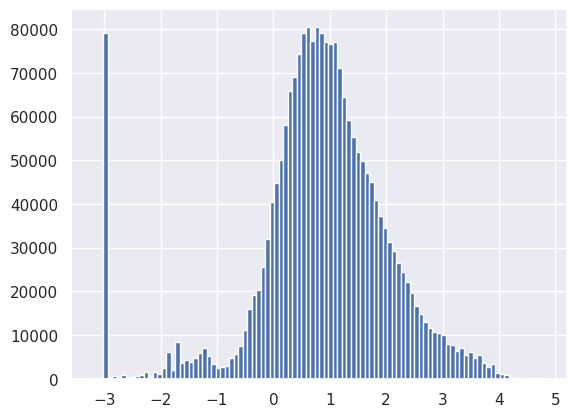

In [23]:
plt.hist(X_missing.flatten(), bins=100)
plt.show()

## User Encodings

In [24]:
NUM_TOPICS = 10
VOCAB_SIZE = 100
ALPHA = 1.0/NUM_TOPICS
fit_kwargs = {"lda": {'doc_topic_prior': ALPHA,  ## alpha
                      'topic_word_prior': 1.0/VOCAB_SIZE, ## eta
                      'perp_tol': 5e-2, 
                      'max_iter': 100, ## number of epochs
                      'batch_size': 64, 
                      'verbose': True, 
                      'learning_method': 'online', 
                      'evaluate_every': 10},}

In [25]:
entity_model = EntityEncoder(num_topics=NUM_TOPICS, reduce_dim=True, num_clusters=VOCAB_SIZE, random_state=RANDOM_SEED).fit(X_missing.reshape(num_users, num_days, -1), fit_kwargs)

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100, perplexity: 28.2278
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100, perplexity: 27.3261
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100, perplexity: 27.0564
iteration: 31 of

In [26]:
user_gamma = entity_model.transform(X_missing.reshape(num_users, num_days, -1))

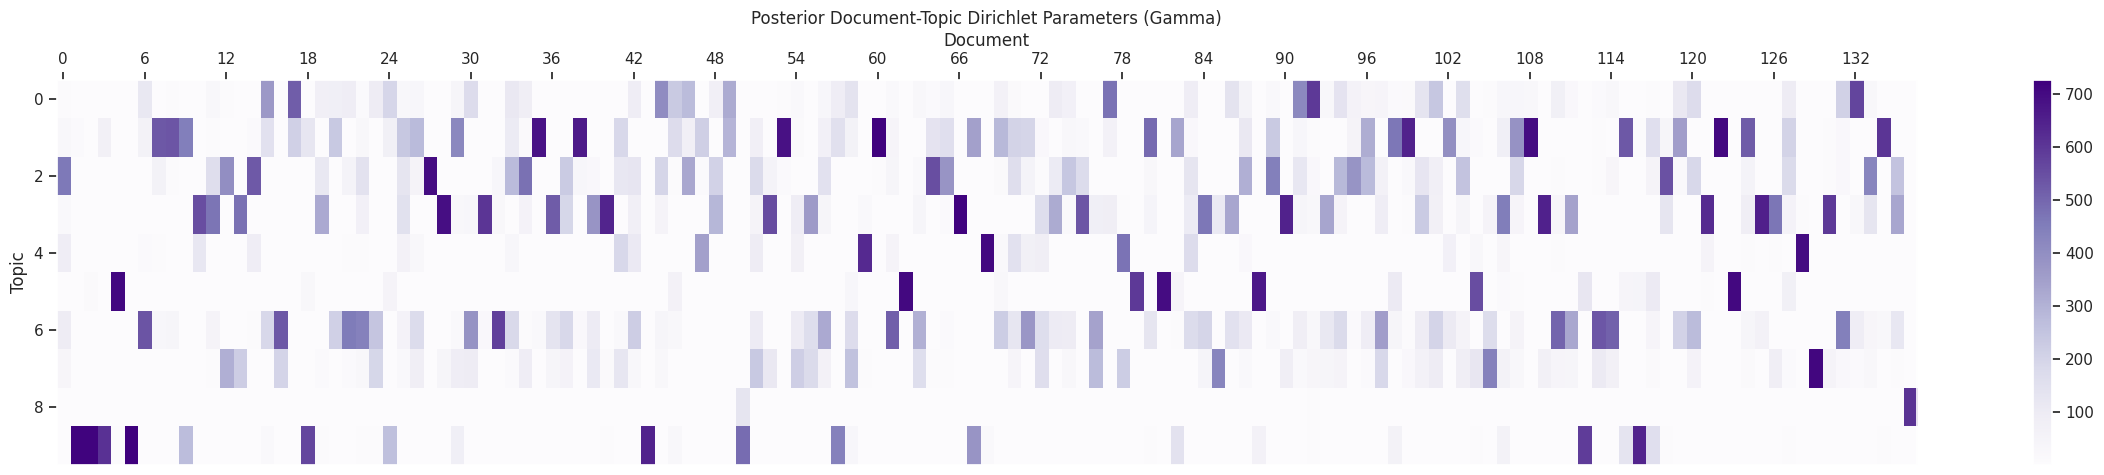

In [27]:
fig, ax = plt.subplots(figsize=(30,5))
im = ax.imshow(user_gamma.T, aspect='auto', cmap='Purples', interpolation='none')
ax.set_title('Posterior Document-Topic Dirichlet Parameters (Gamma)')
ax.set_ylabel('Topic')
ax.set_xlabel('Document')
ax.set_yticks(np.arange(NUM_TOPICS))
ax.set_xticks(np.arange(num_users))
ax.xaxis.tick_top()
ax.yaxis.tick_left()
ax.xaxis.set_label_position('top')
ax.grid(False)
plt.yticks(np.arange(0, NUM_TOPICS, NUM_TOPICS//5))
plt.xticks(np.arange(0, num_users, num_users//20))
fig.colorbar(im, ax=ax)
plt.show()

### Turn embeddings into conditions

In [28]:
conditioner.add_condition(tag="users", typ="dir", support=[ALPHA, entity_model.doc_lengths.max()], data=user_gamma)

In [29]:
conditions_missing["users"] = user_gamma.repeat(num_days, axis=0)

## Ctd

In [30]:
X_missing = X_missing[~missing_idx]
conditions_missing = {k: v[~missing_idx] for k, v in conditions_missing.items()}

In [31]:
## split the X_missing and conditions_missing into training and validation sets
VAL_RATIO = 0.2
random_idx = np.random.permutation(len(X_missing))
val_idx = random_idx[:int(len(X_missing)*VAL_RATIO)]
train_idx = random_idx[int(len(X_missing)*VAL_RATIO):]

X_train, X_val = X_missing[train_idx], X_missing[val_idx]
conditions_train = {k: v[train_idx] for k, v in conditions_missing.items()}
conditions_val = {k: v[val_idx] for k, v in conditions_missing.items()}

In [32]:
trainset = datasets.ConditionedDataset(inputs=X_train, conditions=conditions_train, conditioner=conditioner)
valset = datasets.ConditionedDataset(inputs=X_val, conditions=conditions_val, conditioner=conditioner)
print(f"Number of Training Points: {len(trainset)}")
print(f"Number of Validation Points: {len(valset)}")

Number of Training Points: 72875
Number of Validation Points: 18218


### Model

In [33]:
distribution_dict = {"posterior": {"dist_type": "normal",
                                    "learn_sigma": True,
                                    "sigma_lim": 0.01,
                                    "num_neurons": 250,
                                    "num_hidden_layers": 5,
                                    "dropout": True,
                                    "dropout_rate": 0.10,
                                    "batch_normalization": True,
                                    "resnet": True},
                    "likelihood": {"dist_type": "mixed",
                                    "continuous_dist_type": "normal", 
                                    "learn_sigma": True,
                                    "sigma_lim": 0.01,
                                    "sigma_fixed": 0.1,
                                    "num_neurons": 250,
                                    "num_hidden_layers": 3,
                                    "dropout": True,
                                    "dropout_rate": 0.10,
                                    "batch_normalization": True,
                                    "resnet": True}
                    }

In [34]:
model_kwargs = {"latent_dim": 10,
                "condencoding_dim": None,
                "distribution_dict": distribution_dict,
                }

In [35]:
model = CVAE(input_dim=num_features, conditioner=conditioner, **model_kwargs)
print("Number of encoder parameters:", model.encoder._num_parameters())
print("Number of decoder parameters:", model.decoder._num_parameters())

Number of encoder parameters: 522020
Number of decoder parameters: 600322


### Training

In [79]:
train_kwargs = {
                "lr": 5e-3,
                "beta": 1.0,
                "num_mc_samples": 1,
                "epochs": 10,
                "verbose_freq": 100,
                "tensorboard": True,
                "batch_size": 1024,
                "validation_freq": 250,
                "device": "cuda",
                "tqdm_func": tqdm.tqdm,
                }

In [80]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_kwargs["batch_size"], shuffle=True, drop_last=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=train_kwargs["batch_size"]*128, drop_last=False)

In [123]:
model.fit(trainloader=trainloader, valloader=valloader, **train_kwargs)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration in Epoch:   0%|          | 0/71 [00:00<?, ?it/s]

Iteration: 100 -- ELBO=-2.58e+01 / RLL=-2.14e+01 / KL=4.38e+00
Iteration: 200 -- ELBO=-2.20e+01 / RLL=-1.87e+01 / KL=3.39e+00
Validation -- ELBO=-1.95e+01 / RLL=-1.65e+01 / KL=2.98e+00
Iteration: 300 -- ELBO=-2.07e+01 / RLL=-1.71e+01 / KL=3.59e+00
Iteration: 400 -- ELBO=-1.99e+01 / RLL=-1.64e+01 / KL=3.50e+00
Validation -- ELBO=-1.84e+01 / RLL=-1.52e+01 / KL=3.19e+00
Iteration: 500 -- ELBO=-2.08e+01 / RLL=-1.71e+01 / KL=3.68e+00
Iteration: 600 -- ELBO=-2.00e+01 / RLL=-1.61e+01 / KL=3.86e+00
Iteration: 700 -- ELBO=-1.98e+01 / RLL=-1.60e+01 / KL=3.82e+00


In [124]:
model.to("cpu")
model.prior_params = {k: v.to("cpu") for k, v in model.prior_params.items()}
model.eval()

CVAE(
  (encoder): GaussianNN(
    (parameterizer): ParameterizerNN(
      (block_dict): ModuleDict(
        (input): NNBlock(
          (input_layer): Sequential(
            (0): Linear(in_features=41, out_features=250, bias=True)
            (1): Softplus(beta=1.0, threshold=20.0)
            (2): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (3): Dropout(p=0.1, inplace=False)
          )
          (middle_layers): ModuleList(
            (0-4): 5 x Sequential(
              (0): Linear(in_features=250, out_features=250, bias=True)
              (1): Softplus(beta=1.0, threshold=20.0)
              (2): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (3): Dropout(p=0.1, inplace=False)
            )
          )
          (output_layer): Sequential(
            (0): Linear(in_features=250, out_features=250, bias=True)
            (1): Softplus(beta=1.0, threshold=20.0)
            (2): BatchN

In [125]:
save_path = model.log_dir
model_name = f'trained_model'
model_path = f'./{save_path}/{model_name}.pt'
torch.save(model.state_dict(), model_path)
print(f'Model saved at {model_path}')

Model saved at ./runs/May11_18-45-52_iepg-compute1.ewi.tudelft.nl/trained_model.pt


In [126]:
conditioner_path = f'./{save_path}/conditioner.pkl'
with open(conditioner_path, 'wb') as f: pickle.dump(conditioner, f)
print(f'Conditioner saved at {conditioner_path}')

Conditioner saved at ./runs/May11_18-45-52_iepg-compute1.ewi.tudelft.nl/conditioner.pkl


## Load the Trained Model (if needed)

In [36]:
LOAD_MODEL = True

model_path = None
conditioner_path = None

## if model_path is None, load the latest model
if model_path is None:
    model_path = sorted([f for f in os.listdir("runs")])[-1]
    model_path = f'runs/{model_path}/trained_model.pt'

## if conditioner_path is None, load the latest conditioner
if conditioner_path is None:
    conditioner_path = sorted([f for f in os.listdir("runs")])[-1]
    conditioner_path = f'runs/{conditioner_path}/conditioner.pkl'

In [37]:
if LOAD_MODEL:
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to("cpu")
    model.prior_params = {k: v.to("cpu") for k, v in model.prior_params.items()}
    model.eval()

    with open(conditioner_path, 'rb') as f: conditioner = pickle.load(f)

    print(f'Model loaded from {model_path}')
    print(f'Conditioner loaded from {conditioner_path}')

Model loaded from runs/May11_18-45-52_iepg-compute1.ewi.tudelft.nl/trained_model.pt
Conditioner loaded from runs/May11_18-45-52_iepg-compute1.ewi.tudelft.nl/conditioner.pkl


## Inspection

### Random sample

In [42]:
random_conditions = conditioner.get_random_conditions(1)
## print random_conditions dictionary as a table
print("{:<20}{:>5}".format("Condition", "Value"))
print("="*25)
for k, v in random_conditions[1].items():
    print(f"{k:<20}" + " ".join([f"{x:.2f}" for x in v[0]]))

Condition           Value
months              11.00
is_weekend          0.00
temp_min            18.25
temp_max_delta      7.81
precipitation_level 4.00
users               18.65 49.70 12.75 112.41 26.74 61.86 12.46 32.50 19.54 25.06


In [43]:
x_sample = model.sample(condition=torch.tensor(random_conditions[0]).float(), num_samples_prior=1, num_samples_likelihood=1)
x_mu = x_sample["params"]["mu"].detach()
x_sigma = x_sample["params"]["sigma"].detach()
x_pi = x_sample["params"]["pi"].detach()
x_mu_denorm = utils.zero_preserved_log_denormalize(x_mu, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)*x_pi.numpy()
x_sigma_upper_denorm = utils.zero_preserved_log_denormalize(x_mu+x_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)*x_pi.numpy()
x_sigma_lower_denorm = utils.zero_preserved_log_denormalize(x_mu-x_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)*x_pi.numpy()

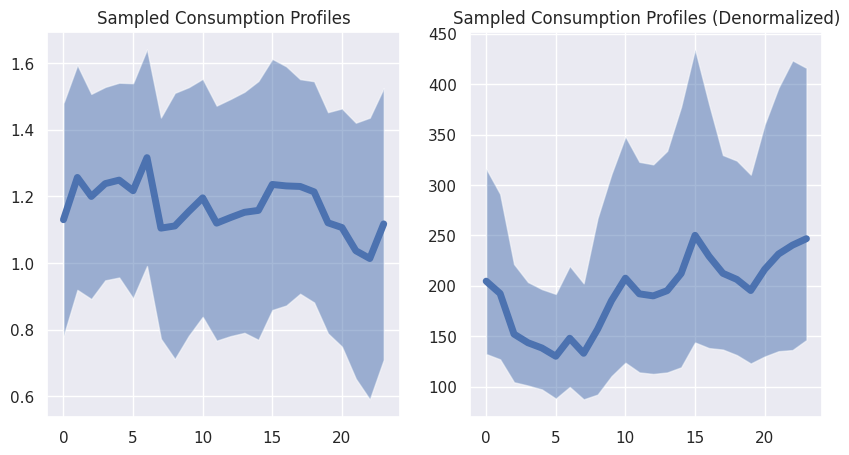

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(x_mu.T, lw=5)
ax[0].fill_between(np.arange(x_mu.shape[1]), (x_mu-x_sigma)[0], (x_mu+x_sigma)[0], alpha=0.5)
# ax[0].plot(x_pi.T, lw=1, linestyle='--')
ax[0].set_title("Sampled Consumption Profiles")

ax[1].plot(x_mu_denorm.T, lw=5)
ax[1].fill_between(np.arange(x_mu_denorm.shape[1]), x_sigma_lower_denorm[0], x_sigma_upper_denorm[0], alpha=0.5)
ax[1].set_title("Sampled Consumption Profiles (Denormalized)")

plt.show()

### Reconstruction

In [47]:
### choose k random datapoints from the validation set
k = 5
random_idx = np.random.choice(len(X_val), k)
x_val = torch.tensor(X_val[random_idx]).float()
x_val_conditions = {k: v[random_idx] for k, v in conditions_val.items()}
x_rec, z_rec = model.reconstruct(x_val, torch.tensor(conditioner.transform(x_val_conditions)).float())

x_rec_mu = x_rec["params"]["mu"].detach().squeeze(0)
x_rec_sigma = x_rec["params"]["sigma"].detach().squeeze(0)
x_rec_pi = x_rec["params"]["pi"].detach().squeeze(0)

x_val_denorm = utils.zero_preserved_log_denormalize(x_val.unsqueeze(0), nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT).squeeze()
x_rec_denorm = utils.zero_preserved_log_denormalize(x_rec_mu, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT).squeeze()*x_rec_pi.numpy()
x_rec_denorm_sigma_low = utils.zero_preserved_log_denormalize(x_rec_mu - x_rec_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT).squeeze()*x_rec_pi.numpy()
x_rec_denorm_sigma_high = utils.zero_preserved_log_denormalize(x_rec_mu + x_rec_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT).squeeze()*x_rec_pi.numpy()


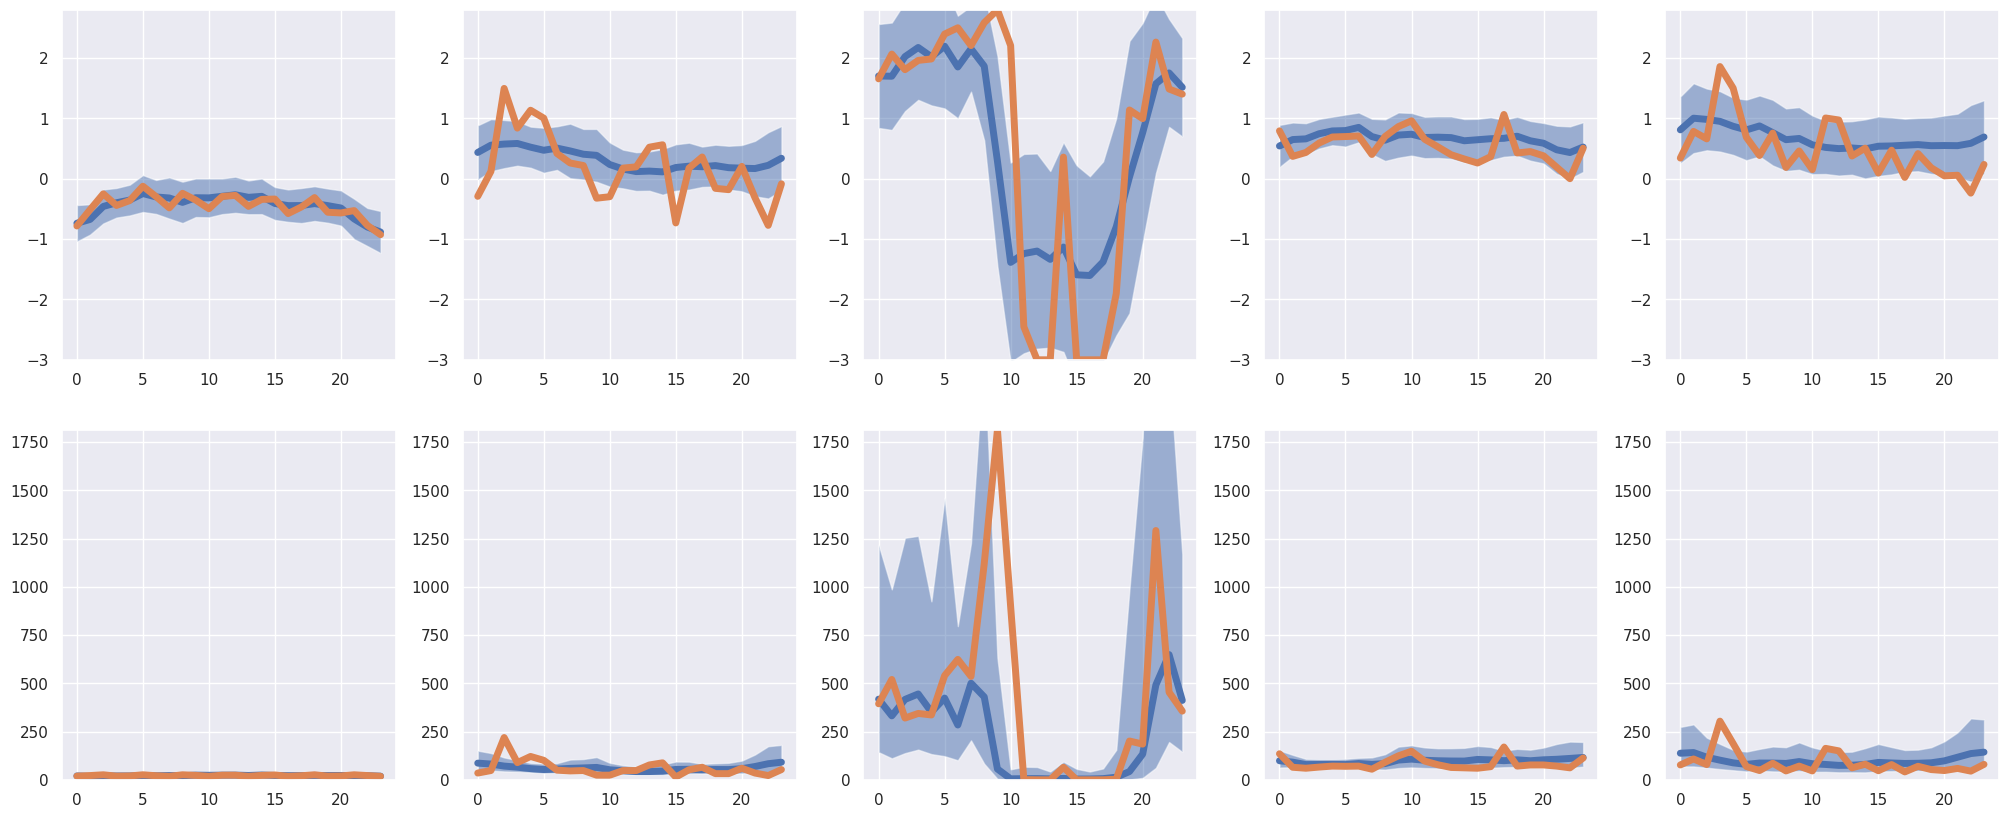

In [48]:
fig, ax = plt.subplots(2, k, figsize=(5*k, 10))

for i in range(k):
    ax[0, i].plot(x_rec_mu[i], lw=5)
    ax[0, i].fill_between(np.arange(x_val.shape[1]), (x_rec_mu-x_rec_sigma)[i], (x_rec_mu+x_rec_sigma)[i],alpha=0.5)
    ax[0, i].plot(x_val[i], lw=5)
    ax[0, i].set_ylim([torch.min(x_val).item(), torch.max(x_val).item()])

    ax[1, i].plot(x_rec_denorm[i].T, lw=5)
    ax[1, i].fill_between(np.arange(x_val_denorm.shape[1]), x_rec_denorm_sigma_low[i].T, x_rec_denorm_sigma_high[i].T, alpha=0.5)
    ax[1, i].plot(x_val_denorm[i].T, lw=5)
    ax[1, i].set_ylim([np.min(x_val_denorm).item(), np.max(x_val_denorm).item()])

### Topic representatives

In [49]:
random_conditions = conditioner.get_random_conditions(1)
print("{:<20}{:>5}".format("Condition", "Value"))
print("="*25)
for k, v in random_conditions[1].items():
    print(f"{k:<20}" + " ".join([f"{x:.2f}" for x in v[0]]))

Condition           Value
months              10.00
is_weekend          1.00
temp_min            6.13
temp_max_delta      8.99
precipitation_level 4.00
users               29.78 6.42 28.78 73.79 13.26 12.38 98.32 149.22 0.95 64.30


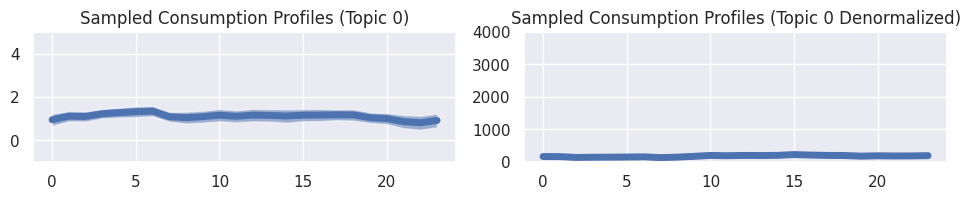

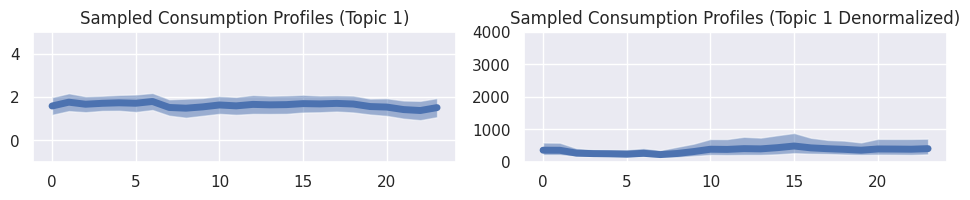

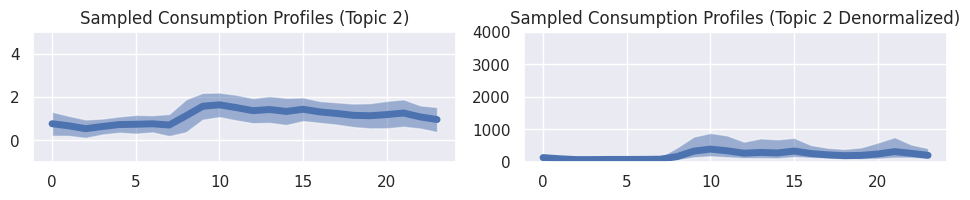

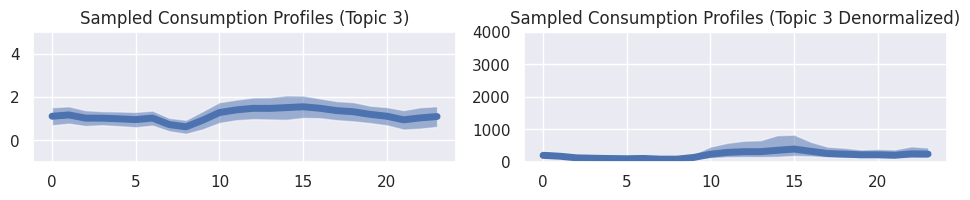

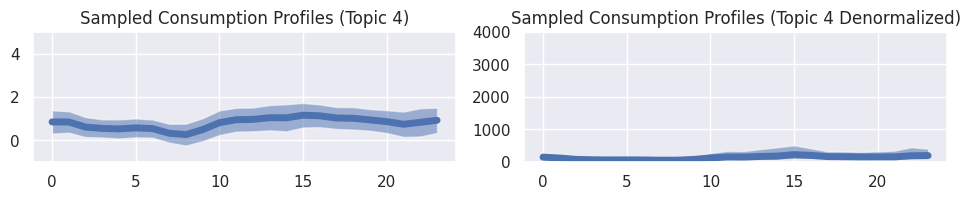

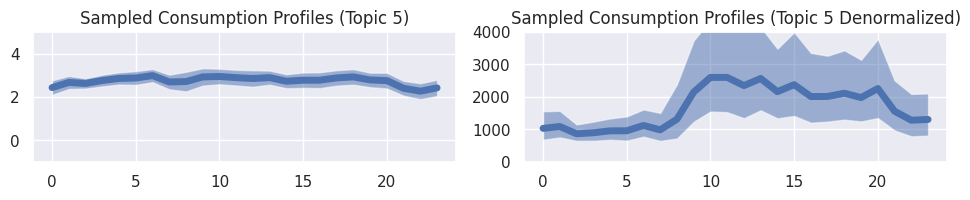

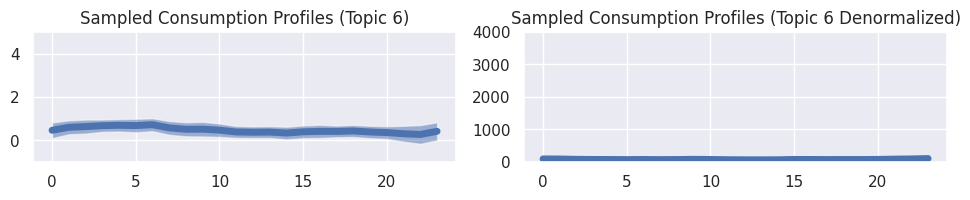

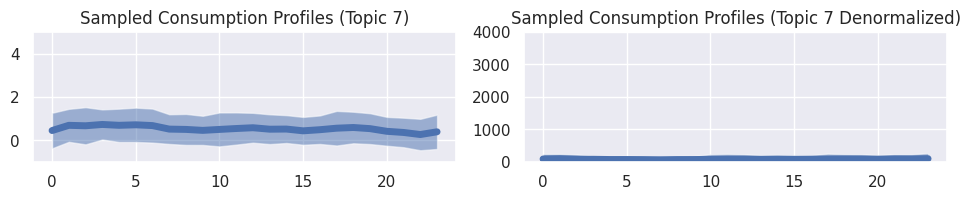

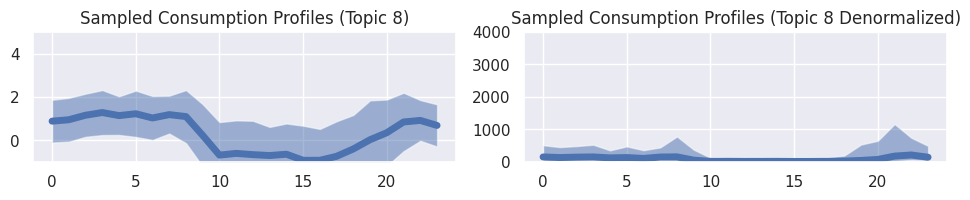

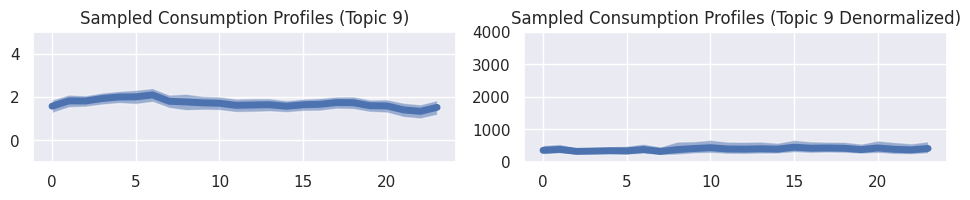

In [50]:
for topic in range(NUM_TOPICS):
    topic_onehot = np.zeros((1, NUM_TOPICS))
    topic_onehot[0, topic] = 1.0
    random_conditions[0][0,-NUM_TOPICS:] = topic_onehot
    x_sample = model.sample(condition=torch.tensor(random_conditions[0]).float(), num_samples_prior=1, num_samples_likelihood=1)
    x_mu = x_sample["params"]["mu"].detach()
    x_sigma = x_sample["params"]["sigma"].detach()
    x_pi = x_sample["params"]["pi"].detach()
    x_mu_denorm = utils.zero_preserved_log_denormalize(x_mu, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)*x_pi.numpy()
    x_sigma_upper_denorm = utils.zero_preserved_log_denormalize(x_mu+x_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)*x_pi.numpy()
    x_sigma_lower_denorm = utils.zero_preserved_log_denormalize(x_mu-x_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)*x_pi.numpy()

    fig, ax = plt.subplots(1, 2, figsize=(10, 2))
    fig.tight_layout()
    ax[0].plot(x_mu.T, lw=5)
    ax[0].fill_between(np.arange(x_mu.shape[1]), (x_mu-x_sigma)[0], (x_mu+x_sigma)[0], alpha=0.5)
    ax[0].set_title(f"Sampled Consumption Profiles (Topic {topic})")
    ax[0].set_ylim([-1, 5])
    
    ax[1].plot(x_mu_denorm.T, lw=5)
    ax[1].fill_between(np.arange(x_mu_denorm.shape[1]), x_sigma_lower_denorm[0], x_sigma_upper_denorm[0], alpha=0.5)
    ax[1].set_title(f"Sampled Consumption Profiles (Topic {topic} Denormalized)")
    ax[1].set_ylim([0, 4000])

    plt.show()
    